In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import interp1d
# import csv
# from pathlib import Path
import os
from van_genuchten import *

Something went wrong with file DuMux_1cm
name 'Path' is not defined
Something went wrong with file DuMux_1cm_rhizo
name 'Path' is not defined
Something went wrong with file OpenSimRoot
name 'Path' is not defined
Something went wrong with file RSWMS
name 'Path' is not defined
Something went wrong with file RSWMS_rhizo
name 'Path' is not defined
Something went wrong with file reference.csv
name 'Path' is not defined
Something went wrong with file DuMuX_1cm


NameError: name 'Path' is not defined

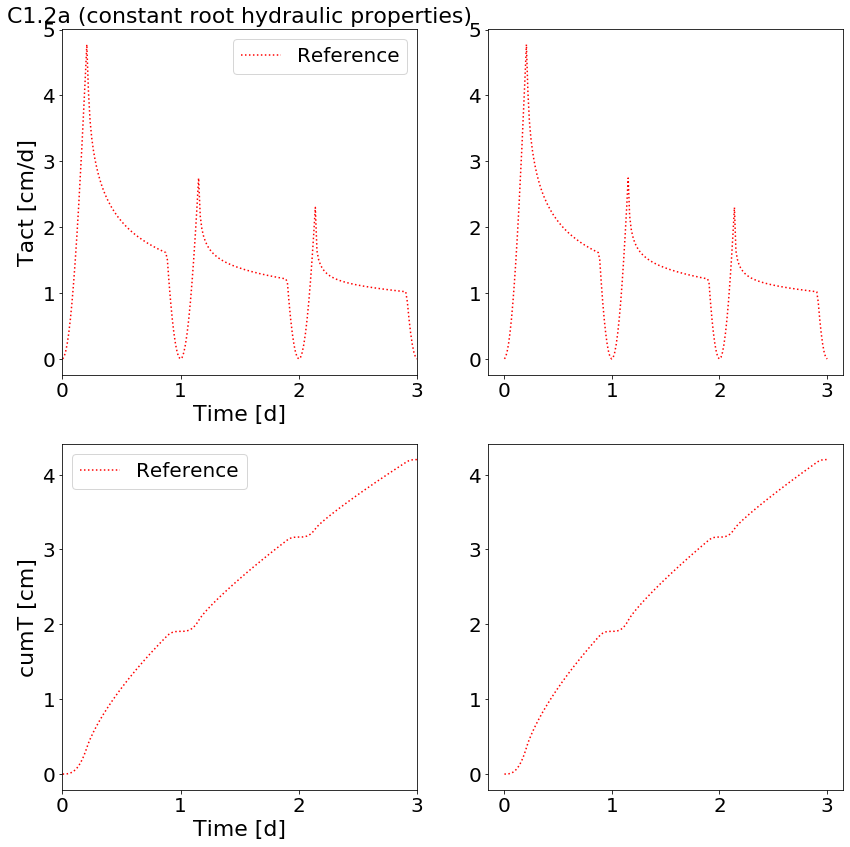

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(14,14)) 
col = ["g-", "b-", "m-", "k-"]*2

# C1.2a
#reference solution
data = np.loadtxt("C1.2a Numerical results/"+"reference.csv",delimiter=';')  
t_a=data[0,:]; y_a=data[1,:]; cumy_a = integrate.cumtrapz(data[1,:],data[0,:],initial=0)
pl, = ax[0,0].plot(t_a,y_a,'r:')
pl, = ax[1,0].plot(t_a,integrate.cumtrapz(y_a,t_a,initial=0),'r:')  
l, nrmsea, namea =["Reference"], [], []
for dirname, dirnames, filenames in os.walk('C1.2a Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            if Path(f).stem != "reference":
                l.append(Path(f).stem);
                data = np.loadtxt("C1.2a Numerical results/"+f,delimiter=';')  
                pl, = ax[0,0].plot(data[0,:],data[1,:],col[i])
                pl, = ax[1,0].plot(data[0,:],integrate.cumtrapz(data[1,:],data[0,:],initial=0),col[i])                  
                interp = interp1d(data[0,:], integrate.cumtrapz(data[1,:],data[0,:],initial=0),  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                cumy_n = interp(t_a) 
                nrmsea.append(nRMSE(cumy_a, cumy_n))
                namea.append(f)
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)  
ax[0,0].set_xlabel("Time [d]")  
ax[0,0].set_ylabel("Tact [cm/d]")  
ax[0,0].legend(l) 
ax[0,0].title.set_text("C1.2a (constant root hydraulic properties)")
ax[0,0].set_xlim(0,3)
ax[1,0].set_xlabel("Time [d]")  
ax[1,0].set_ylabel("cumT [cm]")  
ax[1,0].legend(l) 
ax[1,0].set_xlim(0,3)

# C1.2b
#reference solution
data = np.loadtxt("C1.2b Numerical results/"+"reference.csv",delimiter=';')  
t_a=data[0,:]; y_a=data[1,:]; cumy_a = integrate.cumtrapz(data[1,:],data[0,:],initial=0)
pl, = ax[0,1].plot(t_a,y_a,'r:')
pl, = ax[1,1].plot(t_a,integrate.cumtrapz(y_a,t_a,initial=0),'r:')  
l, nrmseb, nameb =["Reference"], [], []
for dirname, dirnames, filenames in os.walk('C1.2b Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(Path(f).stem); 
            if Path(f).stem != "reference":
                data = np.loadtxt("C1.2b Numerical results/"+f,delimiter=';')  
                pl, = ax[0,1].plot(data[0,:],data[1,:],col[i])
                pl, = ax[1,1].plot(data[0,:],integrate.cumtrapz(data[1,:],data[0,:],initial=0),col[i])                  
                interp = interp1d(data[0,:], integrate.cumtrapz(data[1,:],data[0,:],initial=0),  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                cumy_n = interp(t_a) 
                nrmseb.append(nRMSE(cumy_a, cumy_n))
                nameb.append(Path(f).stem)           
        except Exception as ex:
            print("Something went wrong with file "+f)    
            raise  
ax[0,1].set_xlabel("Time [d]")  
ax[0,1].set_xlim(0,3)
ax[0,1].set_ylabel("Tact [cm/d]")  
ax[0,1].legend(l)            
ax[1,1].set_xlabel("Time [d]")  
ax[1,1].set_ylabel("cumT [cm]")  
ax[1,1].set_xlim(0,3)
ax[1,1].legend(l) 
ax[0,1].title.set_text("C1.2b (age-dependent root hydraulic properties)")

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.savefig('c12_results.png', dpi=300, bbox_inches = "tight")
fig.suptitle("Work in progress")
plt.show() 




In [3]:
# function definitions
# normalized root mean squared error
def nRMSE(y_ana, y_num):
    assert len(y_ana)==len(y_num), "number of analytical solutions y_ana must equalt number of numerical solutions y_num"
    n = len(y_ana)
    rmse = np.sqrt(np.sum(np.square(y_ana-y_num))/n)
    return rmse/np.abs(np.mean(y_ana)) 

IndexError: index 0 is out of bounds for axis 0 with size 0

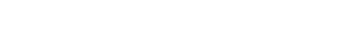

In [4]:
import pandas as pd 

data_ = np.array([namea, nrmsea, nrmseb]); #data_b = pandas.concat([data_, additional], axis=1)
data_ = np.array(data_.transpose())

df = pd.DataFrame(data_, columns = ['Name','nRSME (a)','nRSME (b)'] ) # Create the pandas DataFrame 
df['nRSME (a)'] = df['nRSME (a)'].astype(float)
df['nRSME (a)'] = df['nRSME (a)'].map('{:,.4f}'.format)
df['nRSME (b)'] = df['nRSME (b)'].astype(float)
df['nRSME (b)'] = df['nRSME (b)'].map('{:,.4f}'.format)
# print dataframe. 
df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_c12.png")
